In [2]:
#!pip3 install Pillow

In [3]:
from __future__ import print_function, division
from torchsummary import summary
import os, torch, torchvision, PIL
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from tqdm import tqdm 
import torch.nn as nn 

c:\users\flako\appdata\local\programs\python\python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper Functions

In [4]:
def imshow(img):
  img = img / 2 + 0.5   # unnormalize
  npimg = img.numpy()   # convert from tensor
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  plt.show()
    
def calculate_mu_std(path):
    files = os.listdir(path)
    if ".DS_Store" in files:
        files.remove(".DS_Store")

    if "grayscale" in path:
        rgb_values = np.concatenate( [Image.open(path+img).convert('L').getdata() for img in files], axis=0) / 255.
    # Calculating mean and std for normalization
    else:
        rgb_values = np.concatenate( [Image.open(path+img).getdata() for img in files], axis=0) / 255.

    # rgb_values.shape == (n, 3), 
    # where n is the total number of pixels in all images, 
    # and 3 are the 3 channels: R, G, B.

    # Each value is in the interval [0; 1]

    mu_rgb = np.mean(rgb_values, axis=0)  # mu_rgb.shape == (3,)
    std_rgb = np.std(rgb_values, axis=0)  # std_rgb.shape == (3,)
    return mu_rgb, std_rgb

gray_mu_std = calculate_mu_std("Data/grayscale/train/")
color_mu_std = calculate_mu_std("Data/color/train/")

## Creating Dataset

In [5]:
augmentation = torchvision.transforms.RandomOrder([torchvision.transforms.RandomVerticalFlip(1), 
                                                       torchvision.transforms.RandomHorizontalFlip(1)])

gray_normalized = torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean = gray_mu_std[0],
                                        std = gray_mu_std[1])])


color_normalized = torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean = color_mu_std[0],
                                        std = color_mu_std[1])])
gray_augmented = torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(), augmentation,
                                torchvision.transforms.Normalize(mean = gray_mu_std[0],
                                        std = gray_mu_std[1])])
color_augmented = torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(), augmentation,
                                torchvision.transforms.Normalize(mean = color_mu_std[0],
                                        std = color_mu_std[1])])

# Preparing dataset class
class SneakersDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, normalizer = None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_csv = pd.read_csv(csv_file)
        self.img_dir = root_dir
        self.normalizer = normalizer

        
        #Define dataset
        self.dataset_dir = os.path.join(os.getcwd(), root_dir)
        self.all_filenames = os.listdir(root_dir)
        self.all_labels = pd.read_csv(csv_file, header=0, index_col=0)
        self.label_meanings = self.all_labels.columns.values.tolist()
        
        
    def __len__(self):
        return len(self.data_csv)-1

    def __getitem__(self, idx): 
        #all normalization and data augmentation steps should be applied to the image before this method returns it.
        '''
        if torch.is_tensor(idx):
            idx = idx.tolist()
        '''
        
        file = self.data_csv.iloc[idx, 0]

        if "grayscale" in self.dataset_dir:
            imagepil = Image.open(os.path.join(self.img_dir, file)).convert('L')
        else:
            imagepil = Image.open(os.path.join(self.img_dir, file)).convert('RGB')
        
        #convert image to Tensor and normalize
        if self.normalizer != None:
            transform = self.normalizer
        else:
            transform = torchvision.transforms.ToTensor()
        image = transform(imagepil)

        label = torch.Tensor(self.all_labels.loc[file,:].values)
        sample = {'data':image, #preprocessed image, for input into NN
                  'label':label,
                  'img_idx':idx}
        
        return sample

# Getting datasets
gray_train_augmented = SneakersDataset(csv_file='train.csv', root_dir='Data/grayscale/train/', normalizer = gray_augmented)
gray_train = SneakersDataset(csv_file='train.csv', root_dir='Data/grayscale/train/', normalizer = gray_normalized)
gray_test_dataset = SneakersDataset(csv_file='test.csv', root_dir='Data/grayscale/test/')

color_train_augmented = SneakersDataset(csv_file='train.csv', root_dir='Data/color/train/', normalizer = color_augmented)
color_train = SneakersDataset(csv_file='train.csv', root_dir='Data/color/train/', normalizer = color_normalized)
color_test_dataset =SneakersDataset(csv_file='test.csv', root_dir='Data/color/test/')



# Getting loaders from datasets
gray_train_augmented_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([gray_train,gray_train_augmented]), batch_size=40, shuffle=True)
gray_train_loader = torch.utils.data.DataLoader(gray_train, batch_size = 40, shuffle=True)
gray_test_loader = torch.utils.data.DataLoader(gray_test_dataset, batch_size = 40)

color_train_augmented_loader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([color_train,color_train_augmented]), batch_size=40, shuffle=True)
color_train_loader = torch.utils.data.DataLoader(color_train, batch_size = 40, shuffle=True)
color_test_loader = torch.utils.data.DataLoader(color_test_dataset, batch_size = 40)
classes = ('Jordan 1', 'Jordan 2', 'Jordan 3', 'Jordan 4', 'Jordan 5')

## Defining colored model

In [6]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
    # In this function, you should define each of the individual components of the CNN that you will use in your network 
    # Example:  
    # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    # self.relu1 = nn.ReLU() 
    # self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
    self.cnn1 = nn.Conv2d(3, 6, 5)    
    self.relu1 = nn.ReLU()
    self.cnn2 = nn.Conv2d(6, 7, 3)    
    self.relu2 = nn.ReLU() 
    self.cnn3 = nn.Conv2d(7, 8, 5)    
    self.relu3= nn.ReLU()
    
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    # self.fc1 = nn.Linear(16 *110 * 110, 5)
    # Fully connected 1
    self.fc1 = nn.Linear(8*90*62, 5*8)
    self.relu4 = nn.ReLU()
    self.fc2 = nn.Linear(8*5, 84)
    self.relu5 = nn.ReLU()
    self.fc3 = nn.Linear(84, 5)
    self.visualize = True

  def forward(self,x):
    # TODO: Perform forward pass in below section 
    # In this function, you will apply the components defined earlier to the input, x.
    # Example:
    # out = self.cnn1(x)
    # out = self.relu1(out)      
    # out = self.maxpool1(out) 
    # to visualize feature map in part a, part b.i), use the following three lines:
    first = self.relu1(self.cnn1(x))
    out = self.relu2(self.cnn2(first))
        
    '''
    if self.visualize:
        plt.imshow(out[0][0].cpu().detach().numpy())
        plt.show()
        plt.close('all')
        self.visualize = False
    '''
    third = self.relu3(self.cnn3(out))
    fourth = self.relu4(self.fc1(torch.flatten(third, 1)))
    fifth = self.relu5(self.fc2(fourth))
  
    # plt.imshow(out[0][0].cpu().detach().numpy())
    # plt.show()
    # plt.close('all')
    # out = out.view(out.size(0), -1)
    # out = self.fc1(out)
    
    return self.fc3(fifth)

# TODO: define Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 10**-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 100

NameError: name 'model' is not defined

## Training and testing the model

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
coloredModel = CNNModel()
model.to(device)

count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    for i, info in enumerate(color_train_loader):
        images, labels = info["data"], info['label']
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = model(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for info in color_test_loader:
                images, labels = info["data"], info["label"]
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value

                predicted = torch.argmax(outputs,1)
                true_labels = torch.argmax(labels, 1)
                # Total number of labels
                total += len(true_labels)
                
                correct += (predicted == true_labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy.item())
        if count % 200 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

  3%|██▍                                                                               | 3/100 [00:17<09:11,  5.69s/it]

Iteration: 200  Loss: 0.9192594289779663  Accuracy: 24.30278968811035 %


  7%|█████▋                                                                            | 7/100 [00:40<09:06,  5.88s/it]

Iteration: 400  Loss: 0.3396044969558716  Accuracy: 22.709163665771484 %


 10%|████████                                                                         | 10/100 [00:58<09:01,  6.02s/it]

Iteration: 600  Loss: 0.24226722121238708  Accuracy: 28.685258865356445 %


 14%|███████████▎                                                                     | 14/100 [01:23<08:48,  6.14s/it]

Iteration: 800  Loss: 0.1271335780620575  Accuracy: 38.247013092041016 %


 17%|█████████████▊                                                                   | 17/100 [01:42<08:35,  6.21s/it]

Iteration: 1000  Loss: 0.11984805762767792  Accuracy: 37.05179214477539 %


 21%|█████████████████                                                                | 21/100 [02:07<08:18,  6.31s/it]

Iteration: 1200  Loss: 0.3039023280143738  Accuracy: 35.458168029785156 %


 24%|███████████████████▍                                                             | 24/100 [02:26<07:45,  6.12s/it]

Iteration: 1400  Loss: 0.12081016600131989  Accuracy: 40.637451171875 %


 28%|██████████████████████▋                                                          | 28/100 [02:49<07:04,  5.90s/it]

Iteration: 1600  Loss: 0.3184444308280945  Accuracy: 36.25497817993164 %


 31%|█████████████████████████                                                        | 31/100 [03:07<06:50,  5.94s/it]

Iteration: 1800  Loss: 0.05009564757347107  Accuracy: 41.035858154296875 %


 35%|████████████████████████████▎                                                    | 35/100 [03:30<06:18,  5.82s/it]

Iteration: 2000  Loss: 0.05050197243690491  Accuracy: 45.019920349121094 %


 38%|██████████████████████████████▊                                                  | 38/100 [03:48<06:02,  5.84s/it]

Iteration: 2200  Loss: 0.09136485308408737  Accuracy: 35.458168029785156 %


 42%|██████████████████████████████████                                               | 42/100 [04:11<05:39,  5.86s/it]

Iteration: 2400  Loss: 0.015991006046533585  Accuracy: 43.027889251708984 %


 45%|████████████████████████████████████▍                                            | 45/100 [04:29<05:22,  5.86s/it]

Iteration: 2600  Loss: 0.03142866492271423  Accuracy: 37.05179214477539 %


 49%|███████████████████████████████████████▋                                         | 49/100 [04:52<04:58,  5.85s/it]

Iteration: 2800  Loss: 0.06275513023138046  Accuracy: 36.25497817993164 %


 52%|██████████████████████████████████████████                                       | 52/100 [05:11<04:46,  5.98s/it]

Iteration: 3000  Loss: 0.015387989580631256  Accuracy: 37.05179214477539 %


 56%|█████████████████████████████████████████████▎                                   | 56/100 [05:35<04:24,  6.02s/it]

Iteration: 3200  Loss: 0.10227324068546295  Accuracy: 42.231075286865234 %


 59%|███████████████████████████████████████████████▊                                 | 59/100 [05:53<04:09,  6.08s/it]

Iteration: 3400  Loss: 0.09599848091602325  Accuracy: 39.84063720703125 %


 63%|███████████████████████████████████████████████████                              | 63/100 [06:17<03:44,  6.06s/it]

Iteration: 3600  Loss: 0.05953024700284004  Accuracy: 41.434261322021484 %


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [06:35<03:25,  6.05s/it]

Iteration: 3800  Loss: 0.03932735323905945  Accuracy: 45.816734313964844 %


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [06:59<02:58,  5.96s/it]

Iteration: 4000  Loss: 0.011146599426865578  Accuracy: 40.239044189453125 %


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [07:17<02:43,  6.05s/it]

Iteration: 4200  Loss: 0.0817364901304245  Accuracy: 43.027889251708984 %


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [07:41<02:17,  5.96s/it]

Iteration: 4400  Loss: 0.04640034958720207  Accuracy: 38.247013092041016 %


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [07:59<01:59,  5.97s/it]

Iteration: 4600  Loss: 0.08973316848278046  Accuracy: 40.637451171875 %


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [08:23<01:35,  5.99s/it]

Iteration: 4800  Loss: 0.023955773562192917  Accuracy: 33.46613693237305 %


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [08:41<01:18,  6.06s/it]

Iteration: 5000  Loss: 0.11112852394580841  Accuracy: 35.458168029785156 %


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [09:05<00:53,  5.96s/it]

Iteration: 5200  Loss: 0.015951167792081833  Accuracy: 33.06772994995117 %


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [09:23<00:35,  5.96s/it]

Iteration: 5400  Loss: 0.005196843761950731  Accuracy: 40.239044189453125 %


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [09:47<00:11,  5.97s/it]

Iteration: 5600  Loss: 0.0037954722065478563  Accuracy: 34.661354064941406 %


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:59<00:00,  5.99s/it]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 96, 68]             456
              ReLU-2            [-1, 6, 96, 68]               0
            Conv2d-3            [-1, 7, 94, 66]             385
              ReLU-4            [-1, 7, 94, 66]               0
            Conv2d-5            [-1, 8, 90, 62]           1,408
              ReLU-6            [-1, 8, 90, 62]               0
            Linear-7                   [-1, 40]       1,785,640
              ReLU-8                   [-1, 40]               0
            Linear-9                   [-1, 84]           3,444
             ReLU-10                   [-1, 84]               0
           Linear-11                    [-1, 5]             425
Total params: 1,791,758
Trainable params: 1,791,758
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.08
Forw

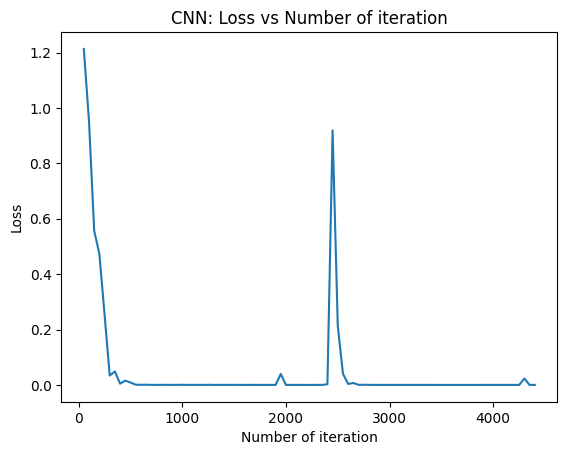

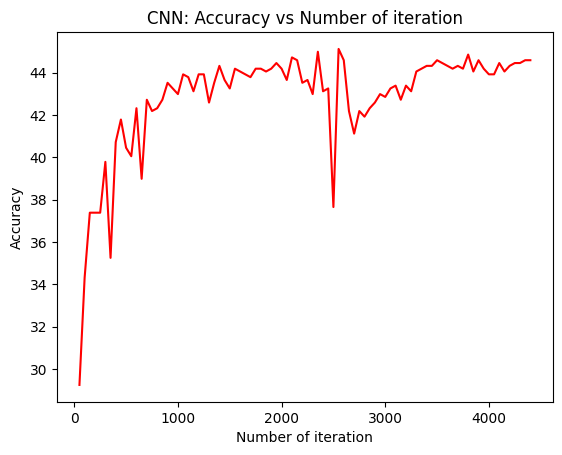

In [26]:
print(summary(model, (3, 100, 72)))

# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

## Defining Gray Model

In [19]:
class CNNGrayModel(nn.Module):
  def __init__(self):
    super(CNNGrayModel, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
    # In this function, you should define each of the individual components of the CNN that you will use in your network 
    # Example:  
    # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    # self.relu1 = nn.ReLU() 
    # self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
    self.cnn1 = nn.Conv2d(1, 2, 5)    
    self.relu1 = nn.ReLU()
    self.cnn2 = nn.Conv2d(2, 3, 3)    
    self.relu2 = nn.ReLU() 
    self.cnn3 = nn.Conv2d(3, 5, 5)    
    self.relu3= nn.ReLU()
    
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    # self.fc1 = nn.Linear(16 *110 * 110, 5)
    # Fully connected 1
    self.fc1 = nn.Linear(5*90*62, 5*5)
    self.relu4 = nn.ReLU()
    self.fc2 = nn.Linear(5*5, 84)
    self.relu5 = nn.ReLU()
    self.fc3 = nn.Linear(84, 5)
    self.visualize = True

  def forward(self,x):
    # TODO: Perform forward pass in below section 
    # In this function, you will apply the components defined earlier to the input, x.
    # Example:
    # out = self.cnn1(x)
    # out = self.relu1(out)      
    # out = self.maxpool1(out) 
    # to visualize feature map in part a, part b.i), use the following three lines:
    first = self.relu1(self.cnn1(x))
    out = self.relu2(self.cnn2(first))
        
    '''
    if self.visualize:
        plt.imshow(out[0][0].cpu().detach().numpy())
        plt.show()
        plt.close('all')
        self.visualize = False
    '''
    third = self.relu3(self.cnn3(out))
    fourth = self.relu4(self.fc1(torch.flatten(third, 1)))
    fifth = self.relu5(self.fc2(fourth))
  
    # plt.imshow(out[0][0].cpu().detach().numpy())
    # plt.show()
    # plt.close('all')
    # out = out.view(out.size(0), -1)
    # out = self.fc1(out)
    
    return self.fc3(fifth)

# TODO: define Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 10**-3
num_epochs = 100

## Training and Testing augmented model

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
gray_model = CNNGrayModel()
gray_model.to(device)
gray_optimizer = torch.optim.Adam(gray_model.parameters(), lr=learning_rate)

count = 0
loss_list = []
iteration_list = []
accuracy_list = []

Tloss_list = []
Titeration_list = []
Taccuracy_list = []

for epoch in tqdm(range(num_epochs)):
    gray_model.train()
    for i, info in enumerate(gray_train_augmented_loader):
        images, labels = info["data"], info['label']
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        gray_optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = gray_model(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        gray_optimizer.step()
        
        count += 1
        if count % 50 == 0:
            for i in range(2):
                if i%2 != 0:
                    gray_model.eval()
                    # Calculate Accuracy         
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for info in gray_test_loader:
                        images, labels = info["data"], info["label"]
                        images, labels = images.to(device), labels.to(device)

                        # Forward propagation
                        outputs = gray_model(images)

                        # Get predictions from the maximum value

                        predicted = torch.argmax(outputs,1)
                        true_labels = torch.argmax(labels, 1)
                        # Total number of labels
                        total += len(true_labels)

                        correct += (predicted == true_labels).sum()

                    accuracy = 100 * correct / float(total)

                    # store loss and iteration
                    loss_list.append(loss.item())
                    iteration_list.append(count)
                    accuracy_list.append(accuracy.item())
                else:
                    gray_model.eval()
                    # Calculate Accuracy         
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for info in gray_train_augmented_loader:
                        images, labels = info["data"], info["label"]
                        images, labels = images.to(device), labels.to(device)

                        # Forward propagation
                        outputs = gray_model(images)

                        # Get predictions from the maximum value

                        predicted = torch.argmax(outputs,1)
                        true_labels = torch.argmax(labels, 1)
                        # Total number of labels
                        total += len(true_labels)

                        correct += (predicted == true_labels).sum()

                    accuracy = 100 * correct / float(total)

                    # store loss and iteration
                    Tloss_list.append(loss.item())
                    Titeration_list.append(count)
                    Taccuracy_list.append(accuracy.item())
                    
        if count % 200 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

  1%|▊                                                                                 | 1/100 [00:14<23:23, 14.17s/it]

Iteration: 200  Loss: 1.341177225112915  Accuracy: 26.10441780090332 %


  3%|██▍                                                                               | 3/100 [00:42<22:45, 14.07s/it]

Iteration: 400  Loss: 1.2151710987091064  Accuracy: 19.277109146118164 %


  5%|████                                                                              | 5/100 [01:13<23:38, 14.93s/it]

Iteration: 600  Loss: 0.7554547190666199  Accuracy: 21.285140991210938 %


  7%|█████▋                                                                            | 7/100 [01:41<22:21, 14.42s/it]

Iteration: 800  Loss: 0.6753185987472534  Accuracy: 27.309236526489258 %


  8%|██████▌                                                                           | 8/100 [01:59<23:35, 15.39s/it]

Iteration: 1000  Loss: 0.49929141998291016  Accuracy: 31.72690773010254 %


 10%|████████                                                                         | 10/100 [02:27<22:02, 14.70s/it]

Iteration: 1200  Loss: 0.40603214502334595  Accuracy: 24.899599075317383 %


 12%|█████████▋                                                                       | 12/100 [02:59<22:35, 15.41s/it]

Iteration: 1400  Loss: 0.24650819599628448  Accuracy: 24.49799156188965 %


 14%|███████████▎                                                                     | 14/100 [03:26<20:54, 14.59s/it]

Iteration: 1600  Loss: 0.11959052085876465  Accuracy: 22.088354110717773 %


 15%|████████████▏                                                                    | 15/100 [03:40<20:23, 14.39s/it]

Iteration: 1800  Loss: 0.10862420499324799  Accuracy: 26.10441780090332 %


 17%|█████████████▊                                                                   | 17/100 [04:12<20:38, 14.92s/it]

Iteration: 2000  Loss: 0.07083964347839355  Accuracy: 21.285140991210938 %


 19%|███████████████▍                                                                 | 19/100 [04:40<19:34, 14.50s/it]

Iteration: 2200  Loss: 0.10192252695560455  Accuracy: 25.301204681396484 %


 21%|█████████████████                                                                | 21/100 [05:11<19:44, 14.99s/it]

Iteration: 2400  Loss: 0.06009586527943611  Accuracy: 24.899599075317383 %


 23%|██████████████████▋                                                              | 23/100 [05:39<18:36, 14.51s/it]

Iteration: 2600  Loss: 0.007342107594013214  Accuracy: 25.70281219482422 %


 24%|███████████████████▍                                                             | 24/100 [05:57<19:30, 15.40s/it]

Iteration: 2800  Loss: 0.0841342955827713  Accuracy: 26.506023406982422 %


 26%|█████████████████████                                                            | 26/100 [06:25<18:02, 14.63s/it]

Iteration: 3000  Loss: 0.038079988211393356  Accuracy: 21.285140991210938 %


 28%|██████████████████████▋                                                          | 28/100 [06:56<17:58, 14.98s/it]

Iteration: 3200  Loss: 0.12946844100952148  Accuracy: 25.70281219482422 %


 30%|████████████████████████▎                                                        | 30/100 [07:23<16:45, 14.37s/it]

Iteration: 3400  Loss: 0.0033434100914746523  Accuracy: 24.49799156188965 %


 31%|█████████████████████████                                                        | 31/100 [07:41<17:35, 15.30s/it]

Iteration: 3600  Loss: 0.05295412614941597  Accuracy: 26.907630920410156 %


 33%|██████████████████████████▋                                                      | 33/100 [08:09<16:14, 14.54s/it]

Iteration: 3800  Loss: 0.07753936201334  Accuracy: 28.514057159423828 %


 35%|████████████████████████████▎                                                    | 35/100 [08:40<16:33, 15.28s/it]

Iteration: 4000  Loss: 0.016915619373321533  Accuracy: 24.49799156188965 %


 37%|█████████████████████████████▉                                                   | 37/100 [09:08<15:23, 14.65s/it]

Iteration: 4200  Loss: 0.038111913949251175  Accuracy: 22.891565322875977 %


 38%|██████████████████████████████▊                                                  | 38/100 [09:22<14:54, 14.43s/it]

Iteration: 4400  Loss: 0.14437335729599  Accuracy: 25.70281219482422 %


 40%|████████████████████████████████▍                                                | 40/100 [09:54<14:59, 14.99s/it]

Iteration: 4600  Loss: 0.008936342783272266  Accuracy: 21.285140991210938 %


 42%|██████████████████████████████████                                               | 42/100 [10:22<13:58, 14.46s/it]

Iteration: 4800  Loss: 0.03874998167157173  Accuracy: 22.489959716796875 %


 44%|███████████████████████████████████▋                                             | 44/100 [10:53<13:54, 14.90s/it]

Iteration: 5000  Loss: 0.002275367733091116  Accuracy: 25.301204681396484 %


 46%|█████████████████████████████████████▎                                           | 46/100 [11:21<13:00, 14.45s/it]

Iteration: 5200  Loss: 0.026009168475866318  Accuracy: 24.899599075317383 %


 47%|██████████████████████████████████████                                           | 47/100 [11:38<13:33, 15.35s/it]

Iteration: 5400  Loss: 0.012703043408691883  Accuracy: 24.49799156188965 %


 49%|███████████████████████████████████████▋                                         | 49/100 [12:06<12:24, 14.59s/it]

Iteration: 5600  Loss: 0.005136235151439905  Accuracy: 25.70281219482422 %


 51%|█████████████████████████████████████████▎                                       | 51/100 [12:37<12:10, 14.92s/it]

Iteration: 5800  Loss: 0.023981105536222458  Accuracy: 24.49799156188965 %


 53%|██████████████████████████████████████████▉                                      | 53/100 [13:05<11:17, 14.42s/it]

Iteration: 6000  Loss: 0.029559101909399033  Accuracy: 26.506023406982422 %


 54%|███████████████████████████████████████████▋                                     | 54/100 [13:23<11:48, 15.39s/it]

Iteration: 6200  Loss: 0.007543535437434912  Accuracy: 24.899599075317383 %


 56%|█████████████████████████████████████████████▎                                   | 56/100 [13:50<10:44, 14.65s/it]

Iteration: 6400  Loss: 0.04769529402256012  Accuracy: 26.10441780090332 %


 58%|██████████████████████████████████████████████▉                                  | 58/100 [14:22<10:47, 15.43s/it]

Iteration: 6600  Loss: 0.011751429177820683  Accuracy: 26.506023406982422 %


 60%|████████████████████████████████████████████████▌                                | 60/100 [14:50<09:50, 14.76s/it]

Iteration: 6800  Loss: 0.0005713709397241473  Accuracy: 26.506023406982422 %


 61%|█████████████████████████████████████████████████▍                               | 61/100 [15:04<09:25, 14.50s/it]

Iteration: 7000  Loss: 6.776429654564708e-05  Accuracy: 26.907630920410156 %


 63%|███████████████████████████████████████████████████                              | 63/100 [15:36<09:11, 14.90s/it]

Iteration: 7200  Loss: 0.00027228042017668486  Accuracy: 26.10441780090332 %


 65%|████████████████████████████████████████████████████▋                            | 65/100 [16:03<08:23, 14.38s/it]

Iteration: 7400  Loss: 0.0031456805299967527  Accuracy: 25.301204681396484 %


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [16:35<08:11, 14.90s/it]

Iteration: 7600  Loss: 4.59523216704838e-05  Accuracy: 27.309236526489258 %


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [17:03<07:26, 14.40s/it]

Iteration: 7800  Loss: 0.05601520091295242  Accuracy: 26.907630920410156 %


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [17:20<07:39, 15.33s/it]

Iteration: 8000  Loss: 0.09095579385757446  Accuracy: 26.10441780090332 %


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [17:48<06:52, 14.72s/it]

Iteration: 8200  Loss: 0.010261409915983677  Accuracy: 25.70281219482422 %


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [18:20<06:40, 15.39s/it]

Iteration: 8400  Loss: 0.00860515609383583  Accuracy: 25.301204681396484 %


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [18:48<05:51, 14.65s/it]

Iteration: 8600  Loss: 0.0008842002716846764  Accuracy: 25.301204681396484 %


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [19:05<05:56, 15.49s/it]

Iteration: 8800  Loss: 0.0024468700867146254  Accuracy: 25.301204681396484 %


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [19:33<05:07, 14.63s/it]

Iteration: 9000  Loss: 0.00199917983263731  Accuracy: 25.301204681396484 %


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [20:04<04:52, 15.40s/it]

Iteration: 9200  Loss: 0.00586352776736021  Accuracy: 25.301204681396484 %


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [20:32<04:08, 14.60s/it]

Iteration: 9400  Loss: 0.0002904555876739323  Accuracy: 24.899599075317383 %


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [20:46<03:50, 14.43s/it]

Iteration: 9600  Loss: 0.009690366685390472  Accuracy: 25.301204681396484 %


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [21:18<03:30, 15.04s/it]

Iteration: 9800  Loss: 4.751004962599836e-05  Accuracy: 24.899599075317383 %


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [21:46<02:53, 14.43s/it]

Iteration: 10000  Loss: 0.00020124422735534608  Accuracy: 24.899599075317383 %


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [22:17<02:28, 14.90s/it]

Iteration: 10200  Loss: 0.0011551713105291128  Accuracy: 25.301204681396484 %


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [22:45<01:55, 14.45s/it]

Iteration: 10400  Loss: 0.0909007117152214  Accuracy: 26.907630920410156 %


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [23:02<01:47, 15.34s/it]

Iteration: 10600  Loss: 0.13442805409431458  Accuracy: 26.907630920410156 %


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [23:30<01:12, 14.58s/it]

Iteration: 10800  Loss: 0.053157709538936615  Accuracy: 26.10441780090332 %


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [24:01<00:45, 15.29s/it]

Iteration: 11000  Loss: 0.005706312600523233  Accuracy: 25.70281219482422 %


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [24:29<00:14, 14.64s/it]

Iteration: 11200  Loss: 0.008336186408996582  Accuracy: 26.506023406982422 %


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [24:47<00:00, 14.87s/it]


## Training and testing regular model

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
gray_model = CNNGrayModel()
gray_model.to(device)
gray_optimizer = torch.optim.Adam(gray_model.parameters(), lr=learning_rate)

count = 0
Rloss_list = []
Riteration_list = []
Raccuracy_list = []

RTloss_list = []
RTiteration_list = []
RTaccuracy_list = []

for epoch in tqdm(range(num_epochs)):
    gray_model.train()
    for i, info in enumerate(gray_train_loader):
        images, labels = info["data"], info['label']
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        gray_optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = gray_model(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        gray_optimizer.step()
        
        count += 1
        if count % 50 == 0:
            for i in range(2):
                if i%2 != 0:
                    gray_model.eval()
                    # Calculate Accuracy         
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for info in gray_test_loader:
                        images, labels = info["data"], info["label"]
                        images, labels = images.to(device), labels.to(device)

                        # Forward propagation
                        outputs = gray_model(images)

                        # Get predictions from the maximum value

                        predicted = torch.argmax(outputs,1)
                        true_labels = torch.argmax(labels, 1)
                        # Total number of labels
                        total += len(true_labels)

                        correct += (predicted == true_labels).sum()

                    accuracy = 100 * correct / float(total)

                    # store loss and iteration
                    Rloss_list.append(loss.item())
                    Riteration_list.append(count)
                    Raccuracy_list.append(accuracy.item())
                else:
                    gray_model.eval()
                    # Calculate Accuracy         
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for info in gray_train_loader:
                        images, labels = info["data"], info["label"]
                        images, labels = images.to(device), labels.to(device)

                        # Forward propagation
                        outputs = gray_model(images)

                        # Get predictions from the maximum value

                        predicted = torch.argmax(outputs,1)
                        true_labels = torch.argmax(labels, 1)
                        # Total number of labels
                        total += len(true_labels)

                        correct += (predicted == true_labels).sum()

                    accuracy = 100 * correct / float(total)

                    # store loss and iteration
                    RTloss_list.append(loss.item())
                    RTiteration_list.append(count)
                    RTaccuracy_list.append(accuracy.item())
                    
        if count % 200 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

  3%|██▍                                                                               | 3/100 [00:15<08:13,  5.08s/it]

Iteration: 200  Loss: 0.6381795406341553  Accuracy: 24.899599075317383 %


  7%|█████▋                                                                            | 7/100 [00:35<07:56,  5.12s/it]

Iteration: 400  Loss: 0.35809987783432007  Accuracy: 33.33333206176758 %


 10%|████████                                                                         | 10/100 [00:52<08:01,  5.35s/it]

Iteration: 600  Loss: 0.16610099375247955  Accuracy: 32.93172836303711 %


 14%|███████████▎                                                                     | 14/100 [01:12<07:21,  5.14s/it]

Iteration: 800  Loss: 0.030777383595705032  Accuracy: 30.120481491088867 %


 17%|█████████████▊                                                                   | 17/100 [01:30<07:26,  5.38s/it]

Iteration: 1000  Loss: 0.05562734603881836  Accuracy: 35.74297332763672 %


 21%|█████████████████                                                                | 21/100 [01:50<06:47,  5.16s/it]

Iteration: 1200  Loss: 0.5943077206611633  Accuracy: 34.13654708862305 %


 24%|███████████████████▍                                                             | 24/100 [02:07<06:49,  5.38s/it]

Iteration: 1400  Loss: 0.002097529359161854  Accuracy: 35.74297332763672 %


 28%|██████████████████████▋                                                          | 28/100 [02:27<06:10,  5.15s/it]

Iteration: 1600  Loss: 0.0005696440348401666  Accuracy: 34.538150787353516 %


 31%|█████████████████████████                                                        | 31/100 [02:44<06:11,  5.39s/it]

Iteration: 1800  Loss: 0.0007167831645347178  Accuracy: 33.33333206176758 %


 35%|████████████████████████████▎                                                    | 35/100 [03:05<05:35,  5.16s/it]

Iteration: 2000  Loss: 0.0005566704203374684  Accuracy: 37.349395751953125 %


 38%|██████████████████████████████▊                                                  | 38/100 [03:22<05:33,  5.39s/it]

Iteration: 2200  Loss: 0.02709824964404106  Accuracy: 35.341365814208984 %


 42%|██████████████████████████████████                                               | 42/100 [03:42<04:58,  5.14s/it]

Iteration: 2400  Loss: 0.00023157941177487373  Accuracy: 35.341365814208984 %


 45%|████████████████████████████████████▍                                            | 45/100 [03:59<04:58,  5.42s/it]

Iteration: 2600  Loss: 4.1786563087953255e-05  Accuracy: 35.341365814208984 %


 49%|███████████████████████████████████████▋                                         | 49/100 [04:20<04:26,  5.23s/it]

Iteration: 2800  Loss: 0.0003054043045267463  Accuracy: 36.14457702636719 %


 52%|██████████████████████████████████████████                                       | 52/100 [04:38<04:27,  5.57s/it]

Iteration: 3000  Loss: 0.00018241391808260232  Accuracy: 35.341365814208984 %


 56%|█████████████████████████████████████████████▎                                   | 56/100 [04:59<03:58,  5.42s/it]

Iteration: 3200  Loss: 0.0001632383355172351  Accuracy: 36.54618453979492 %


 59%|███████████████████████████████████████████████▊                                 | 59/100 [05:17<03:50,  5.62s/it]

Iteration: 3400  Loss: 0.00030049169436097145  Accuracy: 35.74297332763672 %


 63%|███████████████████████████████████████████████████                              | 63/100 [05:37<03:13,  5.23s/it]

Iteration: 3600  Loss: 0.00018411931523587555  Accuracy: 35.74297332763672 %


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [05:54<03:07,  5.50s/it]

Iteration: 3800  Loss: 5.9849659010069445e-05  Accuracy: 36.947792053222656 %


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [06:15<02:36,  5.21s/it]

Iteration: 4000  Loss: 0.5234661102294922  Accuracy: 36.54618453979492 %


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [06:32<02:28,  5.49s/it]

Iteration: 4200  Loss: 0.003702594665810466  Accuracy: 34.93975830078125 %


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [06:52<01:59,  5.18s/it]

Iteration: 4400  Loss: 0.0001315411936957389  Accuracy: 34.538150787353516 %


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [07:09<01:50,  5.51s/it]

Iteration: 4600  Loss: 0.0001621514093130827  Accuracy: 33.73493957519531 %


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [07:29<01:23,  5.21s/it]

Iteration: 4800  Loss: 0.00029315368738025427  Accuracy: 34.13654708862305 %


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [07:46<01:11,  5.49s/it]

Iteration: 5000  Loss: 7.009131513768807e-05  Accuracy: 34.538150787353516 %


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [08:07<00:46,  5.22s/it]

Iteration: 5200  Loss: 5.0999711675103754e-05  Accuracy: 33.73493957519531 %


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [08:24<00:33,  5.52s/it]

Iteration: 5400  Loss: 1.881852040241938e-05  Accuracy: 34.538150787353516 %


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [08:44<00:10,  5.20s/it]

Iteration: 5600  Loss: 1.4652467143605463e-05  Accuracy: 35.341365814208984 %


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:57<00:00,  5.37s/it]


## Graphs for augmented and regular models

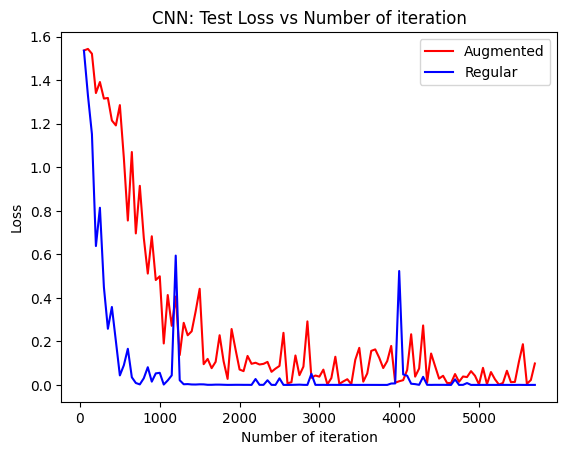

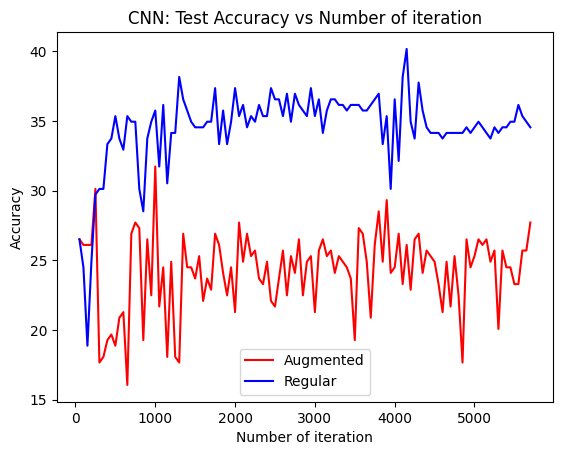

In [11]:
# visualization loss
plt.plot(iteration_list[:len(RTloss_list)],loss_list[:len(RTloss_list)], color = "red", label="Augmented")
plt.plot(Riteration_list,Rloss_list, color = "blue", label="Regular")
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Test Loss vs Number of iteration")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(iteration_list[:len(RTloss_list)],accuracy_list[:len(RTloss_list)],color = "red", label="Augmented")
plt.plot(Riteration_list,Raccuracy_list,color = "blue", label="Regular")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Test Accuracy vs Number of iteration")
plt.legend()
plt.show()

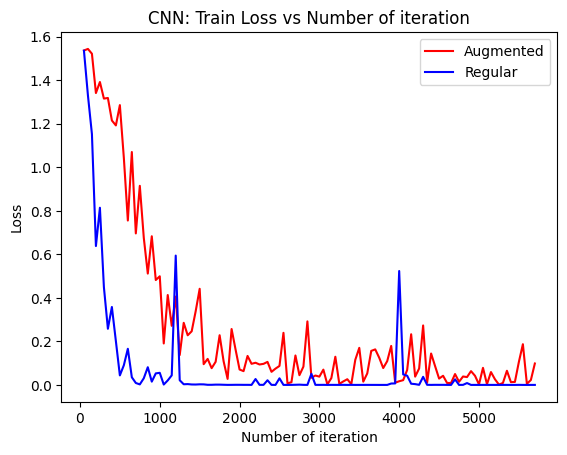

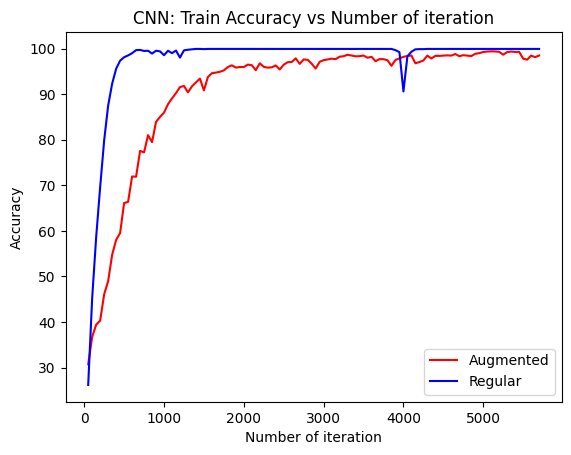

In [12]:
# visualization loss
plt.plot(Titeration_list[:len(RTloss_list)],Tloss_list[:len(RTloss_list)], color = "red", label="Augmented")
plt.plot(RTiteration_list,RTloss_list, color = "blue", label="Regular")
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Train Loss vs Number of iteration")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(Titeration_list[:len(RTloss_list)],Taccuracy_list[:len(RTloss_list)],color = "red", label="Augmented")
plt.plot(RTiteration_list,RTaccuracy_list,color = "blue", label="Regular")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Train Accuracy vs Number of iteration")
plt.legend()
plt.show()

## Training and testing L1regularized model

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
gray_model = CNNGrayModel()
gray_model.to(device)
gray_optimizer = torch.optim.Adam(gray_model.parameters(), lr=learning_rate)

count = 0
reg_loss_list = []
reg_iteration_list = []
reg_accuracy_list = []

regT_loss_list = []
regT_iteration_list = []
regT_accuracy_list = []
gray_lambda = .0001
for epoch in tqdm(range(num_epochs)):
    gray_model.train()
    for i, info in enumerate(gray_train_loader):
        images, labels = info["data"], info['label']
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        gray_optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = gray_model(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        l1_norm = sum(p.abs().sum() for p in gray_model.parameters())
        loss = loss + gray_lambda * l1_norm
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        gray_optimizer.step()
        
        count += 1
        if count % 50 == 0:
            for i in range(2):
                if i%2 != 0:
                    gray_model.eval()
                    # Calculate Accuracy         
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for info in gray_test_loader:
                        images, labels = info["data"], info["label"]
                        images, labels = images.to(device), labels.to(device)

                        # Forward propagation
                        outputs = gray_model(images)

                        # Get predictions from the maximum value

                        predicted = torch.argmax(outputs,1)
                        true_labels = torch.argmax(labels, 1)
                        # Total number of labels
                        total += len(true_labels)

                        correct += (predicted == true_labels).sum()

                    accuracy = 100 * correct / float(total)

                    # store loss and iteration
                    reg_loss_list.append(loss.item())
                    reg_iteration_list.append(count)
                    reg_accuracy_list.append(accuracy.item())
                else:
                    gray_model.eval()
                    # Calculate Accuracy         
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for info in gray_train_loader:
                        images, labels = info["data"], info["label"]
                        images, labels = images.to(device), labels.to(device)

                        # Forward propagation
                        outputs = gray_model(images)

                        # Get predictions from the maximum value

                        predicted = torch.argmax(outputs,1)
                        true_labels = torch.argmax(labels, 1)
                        # Total number of labels
                        total += len(true_labels)

                        correct += (predicted == true_labels).sum()

                    accuracy = 100 * correct / float(total)

                    # store loss and iteration
                    regT_loss_list.append(loss.item())
                    regT_iteration_list.append(count)
                    regT_accuracy_list.append(accuracy.item())
                    
        if count % 200 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

  3%|██▍                                                                               | 3/100 [00:17<09:24,  5.82s/it]

Iteration: 200  Loss: 1.6563442945480347  Accuracy: 26.506023406982422 %


  7%|█████▋                                                                            | 7/100 [00:40<08:57,  5.78s/it]

Iteration: 400  Loss: 1.292090654373169  Accuracy: 31.72690773010254 %


 10%|████████                                                                         | 10/100 [00:59<09:03,  6.04s/it]

Iteration: 600  Loss: 0.8815120458602905  Accuracy: 34.13654708862305 %


 14%|███████████▎                                                                     | 14/100 [01:21<08:00,  5.59s/it]

Iteration: 800  Loss: 0.6140639185905457  Accuracy: 32.93172836303711 %


 17%|█████████████▊                                                                   | 17/100 [01:39<08:00,  5.78s/it]

Iteration: 1000  Loss: 0.6052142381668091  Accuracy: 31.325302124023438 %


 21%|█████████████████                                                                | 21/100 [02:01<07:15,  5.51s/it]

Iteration: 1200  Loss: 0.4047924876213074  Accuracy: 33.33333206176758 %


 24%|███████████████████▍                                                             | 24/100 [02:19<07:15,  5.74s/it]

Iteration: 1400  Loss: 0.40962305665016174  Accuracy: 35.74297332763672 %


 28%|██████████████████████▋                                                          | 28/100 [02:41<06:38,  5.53s/it]

Iteration: 1600  Loss: 0.35856133699417114  Accuracy: 34.93975830078125 %


 31%|█████████████████████████                                                        | 31/100 [02:59<06:36,  5.74s/it]

Iteration: 1800  Loss: 0.3545917868614197  Accuracy: 34.93975830078125 %


 35%|████████████████████████████▎                                                    | 35/100 [03:21<05:57,  5.50s/it]

Iteration: 2000  Loss: 0.3434123992919922  Accuracy: 30.120481491088867 %


 38%|██████████████████████████████▊                                                  | 38/100 [03:39<05:57,  5.77s/it]

Iteration: 2200  Loss: 0.3422972857952118  Accuracy: 35.341365814208984 %


 42%|██████████████████████████████████                                               | 42/100 [04:01<05:19,  5.51s/it]

Iteration: 2400  Loss: 0.31366634368896484  Accuracy: 36.54618453979492 %


 45%|████████████████████████████████████▍                                            | 45/100 [04:21<05:37,  6.14s/it]

Iteration: 2600  Loss: 0.31764402985572815  Accuracy: 37.75100326538086 %


 49%|███████████████████████████████████████▋                                         | 49/100 [04:43<04:48,  5.65s/it]

Iteration: 2800  Loss: 0.21707186102867126  Accuracy: 37.75100326538086 %


 52%|██████████████████████████████████████████                                       | 52/100 [05:01<04:40,  5.85s/it]

Iteration: 3000  Loss: 0.195039302110672  Accuracy: 34.13654708862305 %


 56%|█████████████████████████████████████████████▎                                   | 56/100 [05:23<04:06,  5.61s/it]

Iteration: 3200  Loss: 0.6704898476600647  Accuracy: 26.506023406982422 %


 59%|███████████████████████████████████████████████▊                                 | 59/100 [05:42<04:02,  5.92s/it]

Iteration: 3400  Loss: 0.2889626920223236  Accuracy: 31.72690773010254 %


 63%|███████████████████████████████████████████████████                              | 63/100 [06:03<03:25,  5.55s/it]

Iteration: 3600  Loss: 0.26945793628692627  Accuracy: 33.33333206176758 %


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [06:22<03:19,  5.86s/it]

Iteration: 3800  Loss: 0.2276390939950943  Accuracy: 32.93172836303711 %


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [06:43<02:45,  5.52s/it]

Iteration: 4000  Loss: 0.19558319449424744  Accuracy: 34.93975830078125 %


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [07:01<02:38,  5.86s/it]

Iteration: 4200  Loss: 0.17571420967578888  Accuracy: 33.73493957519531 %


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [07:23<02:07,  5.56s/it]

Iteration: 4400  Loss: 0.4035869240760803  Accuracy: 33.73493957519531 %


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [07:42<01:58,  5.91s/it]

Iteration: 4600  Loss: 0.28226980566978455  Accuracy: 36.54618453979492 %


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [08:04<01:32,  5.76s/it]

Iteration: 4800  Loss: 0.23658178746700287  Accuracy: 35.341365814208984 %


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [08:23<01:18,  6.05s/it]

Iteration: 5000  Loss: 0.2051955908536911  Accuracy: 36.947792053222656 %


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [08:45<00:50,  5.60s/it]

Iteration: 5200  Loss: 0.18004456162452698  Accuracy: 34.93975830078125 %


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [09:03<00:36,  6.04s/it]

Iteration: 5400  Loss: 0.16301873326301575  Accuracy: 34.13654708862305 %


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [09:26<00:11,  5.70s/it]

Iteration: 5600  Loss: 0.511505126953125  Accuracy: 28.112449645996094 %


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:39<00:00,  5.79s/it]


In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
gray_model = CNNGrayModel()
gray_model.to(device)
gray_optimizer = torch.optim.Adam(gray_model.parameters(), lr=learning_rate)

count = 0
reg2_loss_list = []
reg2_iteration_list = []
reg2_accuracy_list = []

regT2_loss_list = []
regT2_iteration_list = []
regT2_accuracy_list = []
gray_lambda = .01
for epoch in tqdm(range(num_epochs)):
    gray_model.train()
    for i, info in enumerate(gray_train_loader):
        images, labels = info["data"], info['label']
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        gray_optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = gray_model(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        l2_norm = sum(p.pow(2.0).sum() for p in gray_model.parameters())
        loss = loss + gray_lambda * l2_norm
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        gray_optimizer.step()
        
        count += 1
        if count % 50 == 0:
            for i in range(2):
                if i%2 != 0:
                    gray_model.eval()
                    # Calculate Accuracy         
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for info in gray_test_loader:
                        images, labels = info["data"], info["label"]
                        images, labels = images.to(device), labels.to(device)

                        # Forward propagation
                        outputs = gray_model(images)

                        # Get predictions from the maximum value

                        predicted = torch.argmax(outputs,1)
                        true_labels = torch.argmax(labels, 1)
                        # Total number of labels
                        total += len(true_labels)

                        correct += (predicted == true_labels).sum()

                    accuracy = 100 * correct / float(total)

                    # store loss and iteration
                    reg2_loss_list.append(loss.item())
                    reg2_iteration_list.append(count)
                    reg2_accuracy_list.append(accuracy.item())
                else:
                    gray_model.eval()
                    # Calculate Accuracy         
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for info in gray_train_loader:
                        images, labels = info["data"], info["label"]
                        images, labels = images.to(device), labels.to(device)

                        # Forward propagation
                        outputs = gray_model(images)

                        # Get predictions from the maximum value

                        predicted = torch.argmax(outputs,1)
                        true_labels = torch.argmax(labels, 1)
                        # Total number of labels
                        total += len(true_labels)

                        correct += (predicted == true_labels).sum()

                    accuracy = 100 * correct / float(total)

                    # store loss and iteration
                    regT2_loss_list.append(loss.item())
                    regT2_iteration_list.append(count)
                    regT2_accuracy_list.append(accuracy.item())
                    
        if count % 200 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

  3%|██▍                                                                               | 3/100 [00:16<08:41,  5.38s/it]

Iteration: 200  Loss: 1.534238576889038  Accuracy: 19.277109146118164 %


  7%|█████▋                                                                            | 7/100 [00:37<08:19,  5.37s/it]

Iteration: 400  Loss: 1.4959704875946045  Accuracy: 35.341365814208984 %


 10%|████████                                                                         | 10/100 [00:55<08:34,  5.71s/it]

Iteration: 600  Loss: 0.826060950756073  Accuracy: 43.37349319458008 %


 14%|███████████▎                                                                     | 14/100 [01:17<07:47,  5.43s/it]

Iteration: 800  Loss: 1.1759146451950073  Accuracy: 49.39759063720703 %


 17%|█████████████▊                                                                   | 17/100 [01:35<07:50,  5.67s/it]

Iteration: 1000  Loss: 0.8278489708900452  Accuracy: 47.79116439819336 %


 21%|█████████████████                                                                | 21/100 [01:56<07:09,  5.43s/it]

Iteration: 1200  Loss: 0.8533366918563843  Accuracy: 41.36546325683594 %


 24%|███████████████████▍                                                             | 24/100 [02:14<07:12,  5.69s/it]

Iteration: 1400  Loss: 0.6798269748687744  Accuracy: 49.39759063720703 %


 28%|██████████████████████▋                                                          | 28/100 [02:36<06:33,  5.47s/it]

Iteration: 1600  Loss: 0.6481508612632751  Accuracy: 46.18473815917969 %


 31%|█████████████████████████                                                        | 31/100 [02:54<06:31,  5.67s/it]

Iteration: 1800  Loss: 0.5562054514884949  Accuracy: 50.200801849365234 %


 35%|████████████████████████████▎                                                    | 35/100 [03:15<05:53,  5.45s/it]

Iteration: 2000  Loss: 0.5912320613861084  Accuracy: 46.58634567260742 %


 38%|██████████████████████████████▊                                                  | 38/100 [03:33<05:49,  5.64s/it]

Iteration: 2200  Loss: 0.736102283000946  Accuracy: 46.18473815917969 %


 42%|██████████████████████████████████                                               | 42/100 [03:55<05:15,  5.45s/it]

Iteration: 2400  Loss: 0.6079548001289368  Accuracy: 48.59437561035156 %


 45%|████████████████████████████████████▍                                            | 45/100 [04:13<05:12,  5.68s/it]

Iteration: 2600  Loss: 0.8994125127792358  Accuracy: 51.807228088378906 %


 49%|███████████████████████████████████████▋                                         | 49/100 [04:34<04:39,  5.48s/it]

Iteration: 2800  Loss: 0.5419135093688965  Accuracy: 47.79116439819336 %


 52%|██████████████████████████████████████████                                       | 52/100 [04:53<04:34,  5.72s/it]

Iteration: 3000  Loss: 0.566929042339325  Accuracy: 46.58634567260742 %


 56%|█████████████████████████████████████████████▎                                   | 56/100 [05:14<04:01,  5.48s/it]

Iteration: 3200  Loss: 0.4525079131126404  Accuracy: 50.200801849365234 %


 59%|███████████████████████████████████████████████▊                                 | 59/100 [05:32<03:57,  5.78s/it]

Iteration: 3400  Loss: 0.5245756506919861  Accuracy: 46.987953186035156 %


 63%|███████████████████████████████████████████████████                              | 63/100 [05:54<03:23,  5.50s/it]

Iteration: 3600  Loss: 0.48385125398635864  Accuracy: 49.799198150634766 %


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [06:12<03:18,  5.85s/it]

Iteration: 3800  Loss: 0.6622021198272705  Accuracy: 52.20883560180664 %


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [06:34<02:47,  5.58s/it]

Iteration: 4000  Loss: 0.45959872007369995  Accuracy: 51.807228088378906 %


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [06:52<02:40,  5.93s/it]

Iteration: 4200  Loss: 0.5006887912750244  Accuracy: 48.192771911621094 %


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [07:14<02:09,  5.64s/it]

Iteration: 4400  Loss: 0.6568003296852112  Accuracy: 49.39759063720703 %


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [07:33<01:58,  5.95s/it]

Iteration: 4600  Loss: 0.5521984100341797  Accuracy: 49.799198150634766 %


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [07:55<01:29,  5.59s/it]

Iteration: 4800  Loss: 0.5168329477310181  Accuracy: 50.200801849365234 %


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [08:13<01:16,  5.88s/it]

Iteration: 5000  Loss: 0.5404990911483765  Accuracy: 53.012046813964844 %


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [08:35<00:49,  5.50s/it]

Iteration: 5200  Loss: 0.444283127784729  Accuracy: 51.40562438964844 %


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [08:52<00:34,  5.80s/it]

Iteration: 5400  Loss: 0.5642935037612915  Accuracy: 44.97991943359375 %


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [09:14<00:11,  5.51s/it]

Iteration: 5600  Loss: 0.47779300808906555  Accuracy: 50.60240936279297 %


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:27<00:00,  5.67s/it]


## Defining model with dropout

In [33]:
class CNNDropGrayModel(nn.Module):
  def __init__(self):
    super(CNNDropGrayModel, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers
    # In this function, you should define each of the individual components of the CNN that you will use in your network 
    # Example:  
    # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    # self.relu1 = nn.ReLU() 
    # self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
    self.cnn1 = nn.Conv2d(1, 2, 5)    
    self.relu1 = nn.ReLU()
    self.cnn2 = nn.Conv2d(2, 3, 3)    
    self.relu2 = nn.ReLU() 
    self.cnn3 = nn.Conv2d(3, 5, 5)    
    self.relu3= nn.ReLU()
    
    
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    # self.fc1 = nn.Linear(16 *110 * 110, 5)
    # Fully connected 1
    self.fc1 = nn.Linear(5*90*62, 5*5)
    self.relu4 = nn.ReLU()
    self.fc2 = nn.Linear(5*5, 84)
    self.relu5 = nn.ReLU()
    self.fc3 = nn.Linear(84, 5)
    self.visualize = True
    self.dropout = nn.Dropout(0.25)

  def forward(self,x):
    # TODO: Perform forward pass in below section 
    # In this function, you will apply the components defined earlier to the input, x.
    # Example:
    # out = self.cnn1(x)
    # out = self.relu1(out)      
    # out = self.maxpool1(out) 
    # to visualize feature map in part a, part b.i), use the following three lines:
    first = self.relu1(self.cnn1(x))
    out = self.relu2(self.cnn2(first))
        
    '''
    if self.visualize:
        plt.imshow(out[0][0].cpu().detach().numpy())
        plt.show()
        plt.close('all')
        self.visualize = False
    '''
    third = self.relu3(self.cnn3(out))
    fourth = self.relu4(self.dropout(self.fc1(torch.flatten(third, 1))))
    fifth = self.relu5(self.fc2(fourth))
  
    # plt.imshow(out[0][0].cpu().detach().numpy())
    # plt.show()
    # plt.close('all')
    # out = out.view(out.size(0), -1)
    # out = self.fc1(out)
    
    return self.fc3(fifth)

# TODO: define Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 10**-3
num_epochs = 100

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
gray_model = CNNDropGrayModel()
gray_model.to(device)
gray_optimizer = torch.optim.Adam(gray_model.parameters(), lr=learning_rate)

count = 0
regDrop_loss_list = []
regDrop_iteration_list = []
regDrop_accuracy_list = []

regTDrop_loss_list = []
regTDrop_iteration_list = []
regTDrop_accuracy_list = []

for epoch in tqdm(range(num_epochs)):
    gray_model.train()
    for i, info in enumerate(gray_train_loader):
        images, labels = info["data"], info['label']
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        gray_optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = gray_model(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        gray_optimizer.step()
        
        count += 1
        if count % 50 == 0:
            for i in range(2):
                if i%2 != 0:
                    gray_model.eval()
                    # Calculate Accuracy         
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for info in gray_test_loader:
                        images, labels = info["data"], info["label"]
                        images, labels = images.to(device), labels.to(device)

                        # Forward propagation
                        outputs = gray_model(images)

                        # Get predictions from the maximum value

                        predicted = torch.argmax(outputs,1)
                        true_labels = torch.argmax(labels, 1)
                        # Total number of labels
                        total += len(true_labels)

                        correct += (predicted == true_labels).sum()

                    accuracy = 100 * correct / float(total)

                    # store loss and iteration
                    regDrop_loss_list.append(loss.item())
                    regDrop_iteration_list.append(count)
                    regDrop_accuracy_list.append(accuracy.item())
                else:
                    gray_model.eval()
                    # Calculate Accuracy         
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for info in gray_train_loader:
                        images, labels = info["data"], info["label"]
                        images, labels = images.to(device), labels.to(device)

                        # Forward propagation
                        outputs = gray_model(images)

                        # Get predictions from the maximum value

                        predicted = torch.argmax(outputs,1)
                        true_labels = torch.argmax(labels, 1)
                        # Total number of labels
                        total += len(true_labels)

                        correct += (predicted == true_labels).sum()

                    accuracy = 100 * correct / float(total)

                    # store loss and iteration
                    regTDrop_loss_list.append(loss.item())
                    regTDrop_iteration_list.append(count)
                    regTDrop_accuracy_list.append(accuracy.item())
                    
        if count % 200 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

  3%|██▍                                                                               | 3/100 [00:15<08:27,  5.24s/it]

Iteration: 200  Loss: 0.9197177886962891  Accuracy: 21.285140991210938 %


  7%|█████▋                                                                            | 7/100 [00:36<08:08,  5.26s/it]

Iteration: 400  Loss: 0.44506826996803284  Accuracy: 34.93975830078125 %


 10%|████████                                                                         | 10/100 [00:54<08:13,  5.48s/it]

Iteration: 600  Loss: 0.4376888871192932  Accuracy: 42.570281982421875 %


 14%|███████████▎                                                                     | 14/100 [01:14<07:32,  5.26s/it]

Iteration: 800  Loss: 0.38649094104766846  Accuracy: 40.9638557434082 %


 17%|█████████████▊                                                                   | 17/100 [01:32<07:35,  5.48s/it]

Iteration: 1000  Loss: 0.24717912077903748  Accuracy: 36.14457702636719 %


 21%|█████████████████                                                                | 21/100 [01:53<06:57,  5.29s/it]

Iteration: 1200  Loss: 0.18930155038833618  Accuracy: 41.767066955566406 %


 24%|███████████████████▍                                                             | 24/100 [02:10<06:57,  5.49s/it]

Iteration: 1400  Loss: 0.28519177436828613  Accuracy: 42.971885681152344 %


 28%|██████████████████████▋                                                          | 28/100 [02:31<06:19,  5.27s/it]

Iteration: 1600  Loss: 0.11615697294473648  Accuracy: 36.54618453979492 %


 31%|█████████████████████████                                                        | 31/100 [02:48<06:18,  5.48s/it]

Iteration: 1800  Loss: 0.15944600105285645  Accuracy: 43.77510070800781 %


 35%|████████████████████████████▎                                                    | 35/100 [03:10<05:53,  5.43s/it]

Iteration: 2000  Loss: 0.08115097135305405  Accuracy: 42.16867446899414 %


 38%|██████████████████████████████▊                                                  | 38/100 [03:28<05:50,  5.65s/it]

Iteration: 2200  Loss: 0.4104331135749817  Accuracy: 36.947792053222656 %


 42%|██████████████████████████████████                                               | 42/100 [03:49<05:16,  5.46s/it]

Iteration: 2400  Loss: 0.09735455363988876  Accuracy: 43.37349319458008 %


 45%|████████████████████████████████████▍                                            | 45/100 [04:07<05:12,  5.69s/it]

Iteration: 2600  Loss: 0.10086574405431747  Accuracy: 35.74297332763672 %


 49%|███████████████████████████████████████▋                                         | 49/100 [04:29<04:39,  5.48s/it]

Iteration: 2800  Loss: 0.2854902744293213  Accuracy: 39.35742950439453 %


 52%|██████████████████████████████████████████                                       | 52/100 [04:47<04:37,  5.77s/it]

Iteration: 3000  Loss: 0.126727893948555  Accuracy: 36.14457702636719 %


 56%|█████████████████████████████████████████████▎                                   | 56/100 [05:09<04:02,  5.50s/it]

Iteration: 3200  Loss: 0.13576030731201172  Accuracy: 40.160640716552734 %


 59%|███████████████████████████████████████████████▊                                 | 59/100 [05:27<04:02,  5.93s/it]

Iteration: 3400  Loss: 0.29825490713119507  Accuracy: 41.36546325683594 %


 63%|███████████████████████████████████████████████████                              | 63/100 [05:49<03:25,  5.55s/it]

Iteration: 3600  Loss: 0.15583766996860504  Accuracy: 44.97991943359375 %


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [06:08<03:23,  5.99s/it]

Iteration: 3800  Loss: 0.17770522832870483  Accuracy: 43.77510070800781 %


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [06:30<02:48,  5.62s/it]

Iteration: 4000  Loss: 0.13638612627983093  Accuracy: 44.17670822143555 %


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [06:48<02:38,  5.88s/it]

Iteration: 4200  Loss: 0.09330492466688156  Accuracy: 40.56224822998047 %


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [07:10<02:09,  5.65s/it]

Iteration: 4400  Loss: 0.16479109227657318  Accuracy: 38.152610778808594 %


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [07:29<01:59,  5.95s/it]

Iteration: 4600  Loss: 0.05789559334516525  Accuracy: 38.55421829223633 %


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [07:51<01:30,  5.65s/it]

Iteration: 4800  Loss: 0.10829372704029083  Accuracy: 38.55421829223633 %


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [08:09<01:18,  6.01s/it]

Iteration: 5000  Loss: 0.0798865407705307  Accuracy: 45.78313064575195 %


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [08:32<00:50,  5.65s/it]

Iteration: 5200  Loss: 0.04769730567932129  Accuracy: 36.947792053222656 %


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [08:49<00:34,  5.79s/it]

Iteration: 5400  Loss: 0.16958722472190857  Accuracy: 48.9959831237793 %


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [09:11<00:10,  5.45s/it]

Iteration: 5600  Loss: 0.07770352810621262  Accuracy: 51.807228088378906 %


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:23<00:00,  5.64s/it]


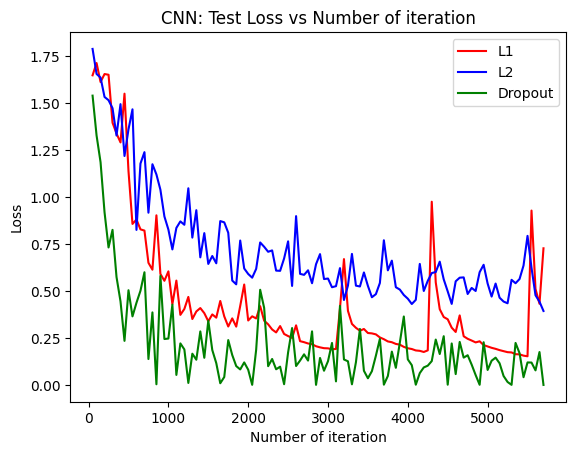

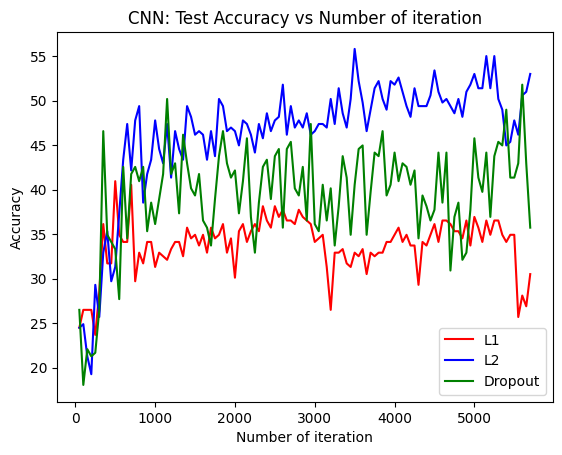

In [35]:
# visualization loss
plt.plot(reg_iteration_list, reg_loss_list, color = "red", label="L1")
plt.plot(reg2_iteration_list, reg2_loss_list, color = "blue", label="L2")
plt.plot(regDrop_iteration_list, regDrop_loss_list, color = "green", label="Dropout")
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Test Loss vs Number of iteration")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(reg_iteration_list, reg_accuracy_list,color = "red", label="L1")
plt.plot(reg2_iteration_list, reg2_accuracy_list,color = "blue", label="L2")
plt.plot(regDrop_iteration_list, regDrop_accuracy_list,color = "green", label="Dropout")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Test Accuracy vs Number of iteration")
plt.legend()
plt.show()

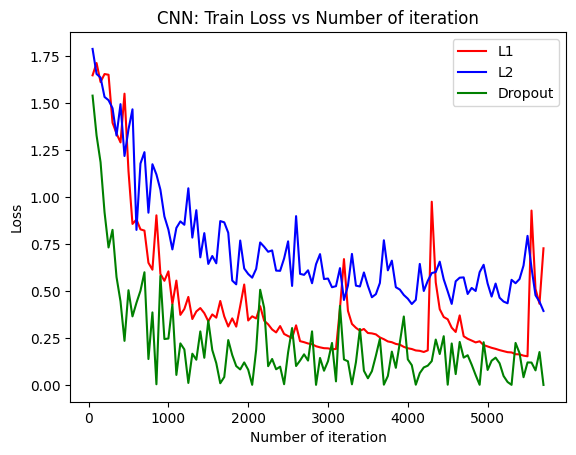

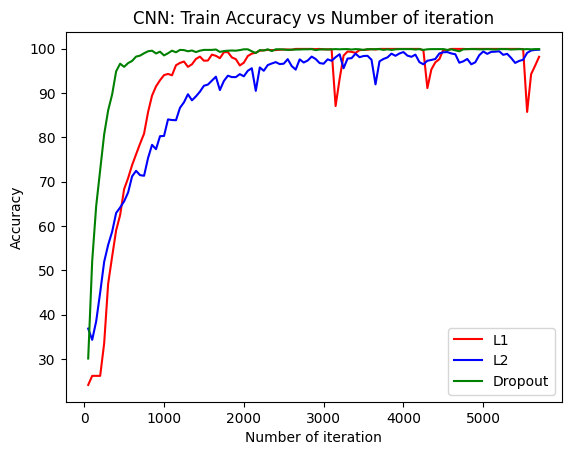

In [36]:
# visualization loss
plt.plot(regT_iteration_list, regT_loss_list, color = "red", label="L1")
plt.plot(regT2_iteration_list, regT2_loss_list, color = "blue", label="L2")
plt.plot(regTDrop_iteration_list, regTDrop_loss_list, color = "green", label="Dropout")
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Train Loss vs Number of iteration")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(regT_iteration_list,regT_accuracy_list,color = "red", label="L1")
plt.plot(regT2_iteration_list,regT2_accuracy_list,color = "blue", label="L2")
plt.plot(regTDrop_iteration_list,regTDrop_accuracy_list,color = "green", label="Dropout")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Train Accuracy vs Number of iteration")
plt.legend()
plt.show()

## Training and testing on Augmented data with dropout and L2

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
gray_model = CNNDropGrayModel()
gray_model.to(device)
gray_optimizer = torch.optim.Adam(gray_model.parameters(), lr=learning_rate)

count = 0
combA_loss_list = []
combA_iteration_list = []
combA_accuracy_list = []

combAT_loss_list = []
combAT_iteration_list = []
combAT_accuracy_list = []
combAgray_lambda = .01

for epoch in tqdm(range(num_epochs)):
    gray_model.train()
    for i, info in enumerate(gray_train_augmented_loader):
        images, labels = info["data"], info['label']
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        gray_optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = gray_model(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        l2_norm = sum(p.pow(2.0).sum() for p in gray_model.parameters())
        loss = loss + gray_lambda * l2_norm
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        gray_optimizer.step()
        
        count += 1
        if count % 50 == 0:
            for i in range(2):
                if i%2 != 0:
                    gray_model.eval()
                    # Calculate Accuracy         
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for info in gray_test_loader:
                        images, labels = info["data"], info["label"]
                        images, labels = images.to(device), labels.to(device)

                        # Forward propagation
                        outputs = gray_model(images)

                        # Get predictions from the maximum value

                        predicted = torch.argmax(outputs,1)
                        true_labels = torch.argmax(labels, 1)
                        # Total number of labels
                        total += len(true_labels)

                        correct += (predicted == true_labels).sum()

                    accuracy = 100 * correct / float(total)

                    # store loss and iteration
                    combA_loss_list.append(loss.item())
                    combA_iteration_list.append(count)
                    combA_accuracy_list.append(accuracy.item())
                else:
                    gray_model.eval()
                    # Calculate Accuracy         
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for info in gray_train_augmented_loader:
                        images, labels = info["data"], info["label"]
                        images, labels = images.to(device), labels.to(device)

                        # Forward propagation
                        outputs = gray_model(images)

                        # Get predictions from the maximum value

                        predicted = torch.argmax(outputs,1)
                        true_labels = torch.argmax(labels, 1)
                        # Total number of labels
                        total += len(true_labels)

                        correct += (predicted == true_labels).sum()

                    accuracy = 100 * correct / float(total)

                    # store loss and iteration
                    combAT_loss_list.append(loss.item())
                    combAT_iteration_list.append(count)
                    combAT_accuracy_list.append(accuracy.item())
                    
        if count % 200 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

  1%|▊                                                                                 | 1/100 [00:14<24:03, 14.58s/it]

Iteration: 200  Loss: 1.6326931715011597  Accuracy: 26.506023406982422 %


  3%|██▍                                                                               | 3/100 [00:43<23:25, 14.49s/it]

Iteration: 400  Loss: 1.4011337757110596  Accuracy: 17.670682907104492 %


  5%|████                                                                              | 5/100 [01:16<24:42, 15.61s/it]

Iteration: 600  Loss: 1.220733880996704  Accuracy: 22.891565322875977 %


  7%|█████▋                                                                            | 7/100 [01:46<23:21, 15.07s/it]

Iteration: 800  Loss: 1.1370830535888672  Accuracy: 22.891565322875977 %


  8%|██████▌                                                                           | 8/100 [02:04<24:57, 16.28s/it]

Iteration: 1000  Loss: 0.8137185573577881  Accuracy: 18.473896026611328 %


 10%|████████                                                                         | 10/100 [02:34<23:07, 15.41s/it]

Iteration: 1200  Loss: 0.5451797246932983  Accuracy: 20.883533477783203 %


 12%|█████████▋                                                                       | 12/100 [03:07<23:37, 16.11s/it]

Iteration: 1400  Loss: 0.8290983438491821  Accuracy: 22.489959716796875 %


 14%|███████████▎                                                                     | 14/100 [03:36<22:03, 15.39s/it]

Iteration: 1600  Loss: 0.879240870475769  Accuracy: 21.68674659729004 %


 15%|████████████▏                                                                    | 15/100 [03:51<21:27, 15.15s/it]

Iteration: 1800  Loss: 0.4764329493045807  Accuracy: 23.29317283630371 %


 17%|█████████████▊                                                                   | 17/100 [04:24<21:43, 15.70s/it]

Iteration: 2000  Loss: 0.3510260581970215  Accuracy: 29.718875885009766 %


 19%|███████████████▍                                                                 | 19/100 [04:53<20:27, 15.16s/it]

Iteration: 2200  Loss: 0.2335224151611328  Accuracy: 30.5220890045166 %


 21%|█████████████████                                                                | 21/100 [05:26<20:42, 15.73s/it]

Iteration: 2400  Loss: 0.8024380803108215  Accuracy: 29.31726837158203 %


 23%|██████████████████▋                                                              | 23/100 [05:55<19:22, 15.10s/it]

Iteration: 2600  Loss: 0.7536695599555969  Accuracy: 25.301204681396484 %


 24%|███████████████████▍                                                             | 24/100 [06:14<20:18, 16.04s/it]

Iteration: 2800  Loss: 0.20939978957176208  Accuracy: 26.907630920410156 %


 26%|█████████████████████                                                            | 26/100 [06:43<18:51, 15.28s/it]

Iteration: 3000  Loss: 0.29587608575820923  Accuracy: 24.49799156188965 %


 28%|██████████████████████▋                                                          | 28/100 [07:17<19:11, 16.00s/it]

Iteration: 3200  Loss: 0.833838701248169  Accuracy: 28.514057159423828 %


 30%|████████████████████████▎                                                        | 30/100 [07:50<19:05, 16.36s/it]

Iteration: 3400  Loss: 0.5195778012275696  Accuracy: 26.506023406982422 %


 31%|█████████████████████████                                                        | 31/100 [08:09<19:44, 17.17s/it]

Iteration: 3600  Loss: 0.2611817419528961  Accuracy: 28.91566276550293 %


 33%|██████████████████████████▋                                                      | 33/100 [08:41<18:29, 16.56s/it]

Iteration: 3800  Loss: 0.2190641611814499  Accuracy: 29.31726837158203 %


 35%|████████████████████████████▎                                                    | 35/100 [09:19<19:36, 18.10s/it]

Iteration: 4000  Loss: 0.5763948559761047  Accuracy: 27.309236526489258 %


 37%|█████████████████████████████▉                                                   | 37/100 [09:53<18:14, 17.37s/it]

Iteration: 4200  Loss: 0.2576662600040436  Accuracy: 30.923694610595703 %


 38%|██████████████████████████████▊                                                  | 38/100 [10:10<18:05, 17.51s/it]

Iteration: 4400  Loss: 0.15798647701740265  Accuracy: 26.907630920410156 %


 40%|████████████████████████████████▍                                                | 40/100 [10:48<17:59, 17.99s/it]

Iteration: 4600  Loss: 0.1578088253736496  Accuracy: 31.325302124023438 %


 42%|██████████████████████████████████                                               | 42/100 [11:21<16:45, 17.34s/it]

Iteration: 4800  Loss: 0.084181047976017  Accuracy: 28.112449645996094 %


 44%|███████████████████████████████████▋                                             | 44/100 [11:59<16:50, 18.04s/it]

Iteration: 5000  Loss: 0.877697229385376  Accuracy: 30.120481491088867 %


 46%|█████████████████████████████████████▎                                           | 46/100 [12:31<15:11, 16.88s/it]

Iteration: 5200  Loss: 0.6718900799751282  Accuracy: 29.31726837158203 %


 47%|██████████████████████████████████████                                           | 47/100 [12:51<15:34, 17.63s/it]

Iteration: 5400  Loss: 0.07439228892326355  Accuracy: 27.309236526489258 %


 49%|███████████████████████████████████████▋                                         | 49/100 [13:22<14:09, 16.65s/it]

Iteration: 5600  Loss: 0.09714789688587189  Accuracy: 27.710844039916992 %


 51%|█████████████████████████████████████████▎                                       | 51/100 [13:56<13:39, 16.73s/it]

Iteration: 5800  Loss: 0.6083934307098389  Accuracy: 28.112449645996094 %


 53%|██████████████████████████████████████████▉                                      | 53/100 [14:26<12:29, 15.95s/it]

Iteration: 6000  Loss: 0.7003041505813599  Accuracy: 24.49799156188965 %


 54%|███████████████████████████████████████████▋                                     | 54/100 [14:45<12:49, 16.72s/it]

Iteration: 6200  Loss: 0.15407970547676086  Accuracy: 28.91566276550293 %


 56%|█████████████████████████████████████████████▎                                   | 56/100 [15:15<11:40, 15.93s/it]

Iteration: 6400  Loss: 0.11836931854486465  Accuracy: 29.718875885009766 %


 58%|██████████████████████████████████████████████▉                                  | 58/100 [15:49<11:37, 16.61s/it]

Iteration: 6600  Loss: 0.7210893630981445  Accuracy: 27.710844039916992 %


 60%|████████████████████████████████████████████████▌                                | 60/100 [16:21<10:45, 16.14s/it]

Iteration: 6800  Loss: 0.4341643154621124  Accuracy: 25.70281219482422 %


 61%|█████████████████████████████████████████████████▍                               | 61/100 [16:36<10:25, 16.04s/it]

Iteration: 7000  Loss: 0.14486509561538696  Accuracy: 30.923694610595703 %


 63%|███████████████████████████████████████████████████                              | 63/100 [17:11<10:08, 16.44s/it]

Iteration: 7200  Loss: 0.16241714358329773  Accuracy: 31.325302124023438 %


 65%|████████████████████████████████████████████████████▋                            | 65/100 [17:41<09:09, 15.69s/it]

Iteration: 7400  Loss: 0.08761092275381088  Accuracy: 28.91566276550293 %


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [18:14<08:49, 16.04s/it]

Iteration: 7600  Loss: 0.5749425292015076  Accuracy: 26.506023406982422 %


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [18:44<07:58, 15.45s/it]

Iteration: 7800  Loss: 0.5756212472915649  Accuracy: 29.718875885009766 %


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [19:03<08:12, 16.42s/it]

Iteration: 8000  Loss: 0.10277584195137024  Accuracy: 31.325302124023438 %


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [19:32<07:17, 15.64s/it]

Iteration: 8200  Loss: 0.0961364135146141  Accuracy: 30.923694610595703 %


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [20:07<07:15, 16.74s/it]

Iteration: 8400  Loss: 0.49805378913879395  Accuracy: 26.506023406982422 %


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [20:38<06:24, 16.02s/it]

Iteration: 8600  Loss: 0.46963945031166077  Accuracy: 29.31726837158203 %


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [20:57<06:33, 17.11s/it]

Iteration: 8800  Loss: 0.11294907331466675  Accuracy: 28.112449645996094 %


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [21:29<05:43, 16.35s/it]

Iteration: 9000  Loss: 0.13017727434635162  Accuracy: 30.120481491088867 %


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [22:04<05:25, 17.14s/it]

Iteration: 9200  Loss: 0.44315388798713684  Accuracy: 30.5220890045166 %


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [22:35<04:36, 16.28s/it]

Iteration: 9400  Loss: 0.4032474458217621  Accuracy: 27.710844039916992 %


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [22:50<04:15, 15.94s/it]

Iteration: 9600  Loss: 0.09046562761068344  Accuracy: 27.309236526489258 %


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [23:25<03:53, 16.71s/it]

Iteration: 9800  Loss: 0.09971354901790619  Accuracy: 28.91566276550293 %


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [23:57<03:14, 16.22s/it]

Iteration: 10000  Loss: 0.1057853102684021  Accuracy: 29.718875885009766 %


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [24:32<02:45, 16.58s/it]

Iteration: 10200  Loss: 0.3213517665863037  Accuracy: 30.923694610595703 %


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [25:03<02:08, 16.04s/it]

Iteration: 10400  Loss: 0.825661301612854  Accuracy: 29.31726837158203 %


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [25:21<01:58, 16.89s/it]

Iteration: 10600  Loss: 0.10665693134069443  Accuracy: 28.514057159423828 %


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [25:51<01:19, 15.94s/it]

Iteration: 10800  Loss: 0.3162558078765869  Accuracy: 33.73493957519531 %


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [26:25<00:50, 16.68s/it]

Iteration: 11000  Loss: 0.595771849155426  Accuracy: 27.309236526489258 %


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [26:56<00:15, 15.93s/it]

Iteration: 11200  Loss: 0.5584579706192017  Accuracy: 30.5220890045166 %


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [27:16<00:00, 16.36s/it]


## Training and Testing on regular data with dropout and L2

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
gray_model = CNNDropGrayModel()
gray_model.to(device)
gray_optimizer = torch.optim.Adam(gray_model.parameters(), lr=learning_rate)

count = 0
comb_loss_list = []
comb_iteration_list = []
comb_accuracy_list = []

combT_loss_list = []
combT_iteration_list = []
combT_accuracy_list = []
gray_lambda = .01

for epoch in tqdm(range(num_epochs)):
    gray_model.train()
    for i, info in enumerate(gray_train_loader):
        images, labels = info["data"], info['label']
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        gray_optimizer.zero_grad()
        
        # TODO: Forward propagation
        outputs = gray_model(images)
        
        # TODO: Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        l2_norm = sum(p.pow(2.0).sum() for p in gray_model.parameters())
        loss = loss + gray_lambda * l2_norm
        
        # Backprop agate your Loss 
        loss.backward()
        
        # Update CNN model  
        gray_optimizer.step()
        
        count += 1
        if count % 50 == 0:
            for i in range(2):
                if i%2 != 0:
                    gray_model.eval()
                    # Calculate Accuracy         
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for info in gray_test_loader:
                        images, labels = info["data"], info["label"]
                        images, labels = images.to(device), labels.to(device)

                        # Forward propagation
                        outputs = gray_model(images)

                        # Get predictions from the maximum value

                        predicted = torch.argmax(outputs,1)
                        true_labels = torch.argmax(labels, 1)
                        # Total number of labels
                        total += len(true_labels)

                        correct += (predicted == true_labels).sum()

                    accuracy = 100 * correct / float(total)

                    # store loss and iteration
                    comb_loss_list.append(loss.item())
                    comb_iteration_list.append(count)
                    comb_accuracy_list.append(accuracy.item())
                else:
                    gray_model.eval()
                    # Calculate Accuracy         
                    correct = 0
                    total = 0
                    # Iterate through test dataset
                    for info in gray_train_loader:
                        images, labels = info["data"], info["label"]
                        images, labels = images.to(device), labels.to(device)

                        # Forward propagation
                        outputs = gray_model(images)

                        # Get predictions from the maximum value

                        predicted = torch.argmax(outputs,1)
                        true_labels = torch.argmax(labels, 1)
                        # Total number of labels
                        total += len(true_labels)

                        correct += (predicted == true_labels).sum()

                    accuracy = 100 * correct / float(total)

                    # store loss and iteration
                    combT_loss_list.append(loss.item())
                    combT_iteration_list.append(count)
                    combT_accuracy_list.append(accuracy.item())
                    
        if count % 200 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

  3%|██▍                                                                               | 3/100 [00:16<08:57,  5.54s/it]

Iteration: 200  Loss: 1.67311692237854  Accuracy: 18.473896026611328 %


  7%|█████▋                                                                            | 7/100 [00:39<08:48,  5.69s/it]

Iteration: 400  Loss: 1.450683355331421  Accuracy: 16.465864181518555 %


 10%|████████                                                                         | 10/100 [00:57<08:42,  5.81s/it]

Iteration: 600  Loss: 1.6347935199737549  Accuracy: 20.080320358276367 %


 14%|███████████▎                                                                     | 14/100 [01:19<07:56,  5.55s/it]

Iteration: 800  Loss: 1.487555980682373  Accuracy: 19.678714752197266 %


 17%|█████████████▊                                                                   | 17/100 [01:38<08:05,  5.85s/it]

Iteration: 1000  Loss: 1.715994954109192  Accuracy: 24.49799156188965 %


 21%|█████████████████                                                                | 21/100 [01:59<07:17,  5.53s/it]

Iteration: 1200  Loss: 1.4220242500305176  Accuracy: 50.200801849365234 %


 24%|███████████████████▍                                                             | 24/100 [02:18<07:21,  5.80s/it]

Iteration: 1400  Loss: 1.1554365158081055  Accuracy: 48.9959831237793 %


 28%|██████████████████████▋                                                          | 28/100 [02:40<06:47,  5.66s/it]

Iteration: 1600  Loss: 1.0476927757263184  Accuracy: 46.987953186035156 %


 31%|█████████████████████████                                                        | 31/100 [02:59<06:54,  6.00s/it]

Iteration: 1800  Loss: 1.1040449142456055  Accuracy: 48.192771911621094 %


 35%|████████████████████████████▎                                                    | 35/100 [03:21<06:05,  5.63s/it]

Iteration: 2000  Loss: 0.9714474678039551  Accuracy: 42.570281982421875 %


 38%|██████████████████████████████▊                                                  | 38/100 [03:40<06:07,  5.92s/it]

Iteration: 2200  Loss: 0.8086490035057068  Accuracy: 48.9959831237793 %


 42%|██████████████████████████████████                                               | 42/100 [04:02<05:22,  5.56s/it]

Iteration: 2400  Loss: 1.1448018550872803  Accuracy: 46.987953186035156 %


 45%|████████████████████████████████████▍                                            | 45/100 [04:20<05:16,  5.76s/it]

Iteration: 2600  Loss: 0.8919260501861572  Accuracy: 47.389556884765625 %


 49%|███████████████████████████████████████▋                                         | 49/100 [04:43<04:53,  5.76s/it]

Iteration: 2800  Loss: 0.8003239631652832  Accuracy: 50.200801849365234 %


 52%|██████████████████████████████████████████                                       | 52/100 [05:02<04:49,  6.02s/it]

Iteration: 3000  Loss: 1.2698136568069458  Accuracy: 42.971885681152344 %


 56%|█████████████████████████████████████████████▎                                   | 56/100 [05:25<04:11,  5.73s/it]

Iteration: 3200  Loss: 0.8277347683906555  Accuracy: 44.97991943359375 %


 59%|███████████████████████████████████████████████▊                                 | 59/100 [05:43<04:06,  6.02s/it]

Iteration: 3400  Loss: 1.2461912631988525  Accuracy: 46.18473815917969 %


 63%|███████████████████████████████████████████████████                              | 63/100 [06:05<03:26,  5.57s/it]

Iteration: 3600  Loss: 0.6762813925743103  Accuracy: 45.381526947021484 %


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [06:23<03:18,  5.84s/it]

Iteration: 3800  Loss: 0.9175410270690918  Accuracy: 46.58634567260742 %


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [06:46<02:55,  5.86s/it]

Iteration: 4000  Loss: 1.0501015186309814  Accuracy: 44.17670822143555 %


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [07:06<02:49,  6.27s/it]

Iteration: 4200  Loss: 1.0005470514297485  Accuracy: 48.192771911621094 %


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [07:28<02:10,  5.68s/it]

Iteration: 4400  Loss: 1.1406939029693604  Accuracy: 46.18473815917969 %


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [07:46<01:57,  5.90s/it]

Iteration: 4600  Loss: 1.4506797790527344  Accuracy: 41.767066955566406 %


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [08:08<01:28,  5.54s/it]

Iteration: 4800  Loss: 0.8038164377212524  Accuracy: 46.987953186035156 %


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [08:26<01:15,  5.82s/it]

Iteration: 5000  Loss: 0.8639156222343445  Accuracy: 41.36546325683594 %


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [08:48<00:49,  5.55s/it]

Iteration: 5200  Loss: 1.115431785583496  Accuracy: 43.77510070800781 %


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [09:07<00:36,  6.02s/it]

Iteration: 5400  Loss: 1.0682425498962402  Accuracy: 44.97991943359375 %


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [09:29<00:11,  5.69s/it]

Iteration: 5600  Loss: 0.8595054149627686  Accuracy: 44.578311920166016 %


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:42<00:00,  5.82s/it]


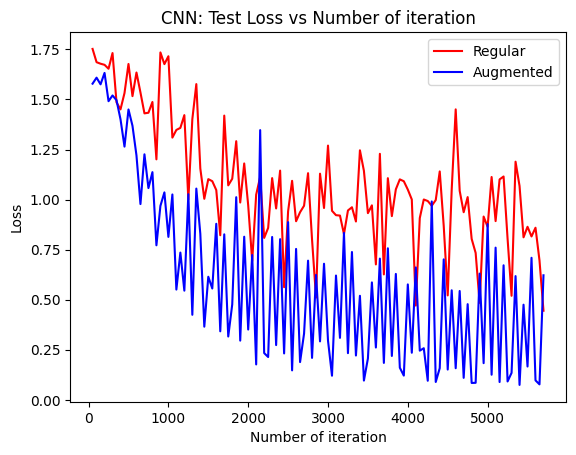

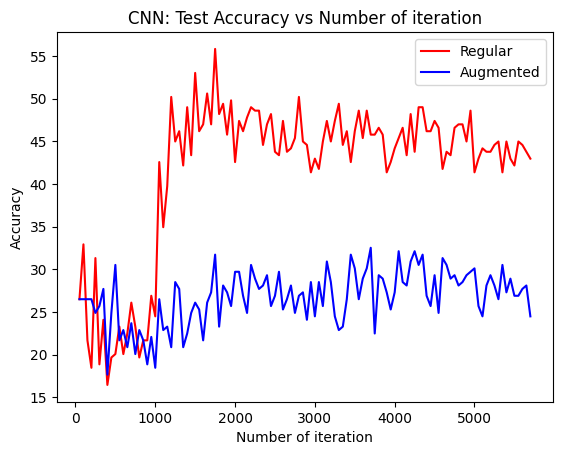

In [41]:
# visualization loss
plt.plot(comb_iteration_list, comb_loss_list, color = "red", label="Regular")
plt.plot(combA_iteration_list[:len(comb_iteration_list)], combA_loss_list[:len(comb_loss_list)], color = "blue", label="Augmented")
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Test Loss vs Number of iteration")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(comb_iteration_list, comb_accuracy_list,color = "red", label="Regular")
plt.plot(combA_iteration_list[:len(comb_iteration_list)], combA_accuracy_list[:len(comb_accuracy_list)],color = "blue", label="Augmented")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Test Accuracy vs Number of iteration")
plt.legend()
plt.show()

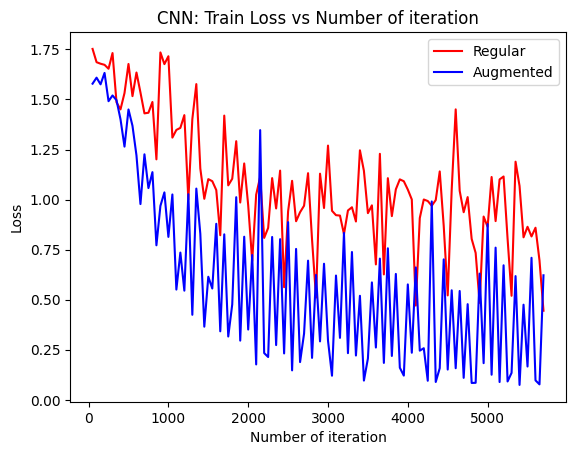

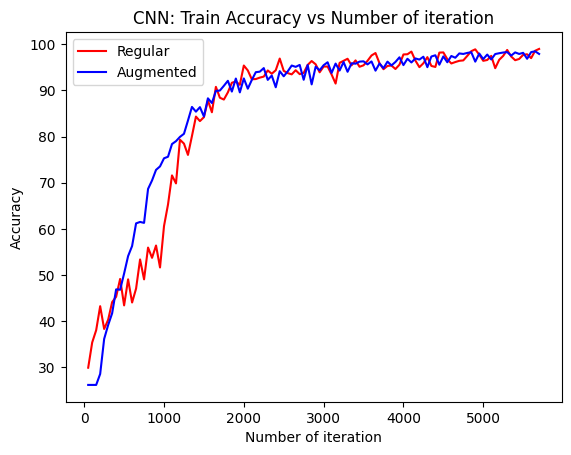

In [44]:
# visualization loss
plt.plot(comb_iteration_list, combT_loss_list, color = "red", label="Regular")
plt.plot(combAT_iteration_list[:len(comb_iteration_list)], combAT_loss_list[:len(combT_loss_list)], color = "blue", label="Augmented")
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Train Loss vs Number of iteration")
plt.legend()
plt.show()

# visualization accuracy 
plt.plot(combT_iteration_list,combT_accuracy_list,color = "red", label="Regular")
plt.plot(combAT_iteration_list[:len(combT_iteration_list)],combAT_accuracy_list[:len(combT_accuracy_list)],color = "blue", label="Augmented")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Train Accuracy vs Number of iteration")
plt.legend()
plt.show()